In [1]:
import numpy as np
import random
import os

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf 

tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
from plot_module import save_plot

import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler

### Loading data and preprocessing

In [3]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)
df['LogVolume'] = np.log(df['Volume']) 
df['DiffLogVolume'] = df['LogVolume'].diff() 
df.head()

,Volume,LogVolume,DiffLogVolume
Production Date,,,
2015-01-01,67515553.0,18.027869,NaN
2015-02-01,61664960.0,17.937226,-0.090642
2015-03-01,66342950.0,18.010348,0.073122
2015-04-01,67719040.0,18.030878,0.020530
2015-05-01,66484591.0,18.012481,-0.018397


### Multi-output Supervised Dataset

In [4]:
series = df['DiffLogVolume'].to_numpy()[1:] 
T = 6
forecast_months = 24

Tx = T 
Ty = forecast_months 

X = [] 
Y = [] 

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (95, 6) Y.shape (95, 24)


### Train/Test Split

In [5]:
Xtrain, Ytrain = X[:-1], Y[:-1]
Xfuture = X[-1:]

### Scaling

In [6]:
scaler_x= MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler_x.fit_transform(Xtrain)
Xtrain = Xtrain.reshape(-1, Tx, 1)

Xfuture = scaler_x.transform(Xfuture)
Xfuture = Xfuture.reshape(-1, Tx, 1)

Ytrain = scaler_y.fit_transform(Ytrain)

### RNN

In [7]:
K.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED) 

initializer = tf.keras.initializers.GlorotUniform(seed=SEED) 

model = Sequential([
        Input(shape =(Tx, 1)),
        LSTM(50, activation='tanh', return_sequences=True,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(0.2, seed=SEED),
        LSTM(50, activation='tanh', return_sequences=False,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(0.2, seed=SEED),
        Dense(Ty, kernel_initializer=initializer, bias_initializer='zeros')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']) 

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Stop if no improvement for 15 epochs
    restore_best_weights=True,  # Restore weights from best epoch
    verbose=1
)

model.summary() 

r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,824 (124.31 KB)

 Trainable params: 31,824 (124.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - loss: 0.1036 - mae: 0.4135 - val_loss: 0.0656 - val_mae: 0.3350
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0570 - mae: 0.2785 - val_loss: 0.0211 - val_mae: 0.1583
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0328 - mae: 0.1990 - val_loss: 0.0092 - val_mae: 0.1084
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0247 - mae: 0.1715 - val_loss: 0.0076 - val_mae: 0.0989
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0230 - mae: 0.1659 - val_loss: 0.0073 - val_mae: 0.0955
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0231 - mae: 0.1674 - val_loss: 0.0074 - val_mae: 0.0988
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0227 - mae: 0.1629 - val_loss: 0.0072 - val_mae: 0.0975
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0225 - mae: 0.1619 - val_loss: 0.0073 - val_mae: 0.0978
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - 

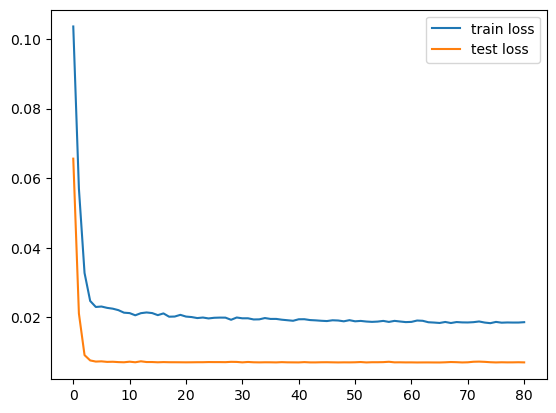

In [8]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Future Forecast

In [9]:
Pfuture = model.predict(Xfuture)
Pfuture = scaler_y.inverse_transform(Pfuture)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [10]:
last_train = df['LogVolume'].iloc[-1] 
last_known_date = df.index[-1]

future_data = last_train + np.cumsum(Pfuture) 

future_dates = pd.date_range(
    start=last_known_date + pd.DateOffset(months=1),
    periods=forecast_months,
    freq='MS'  # Month start
)

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast_LogVolume': future_data,
    'Forecast_Volume': np.exp(future_data)
})

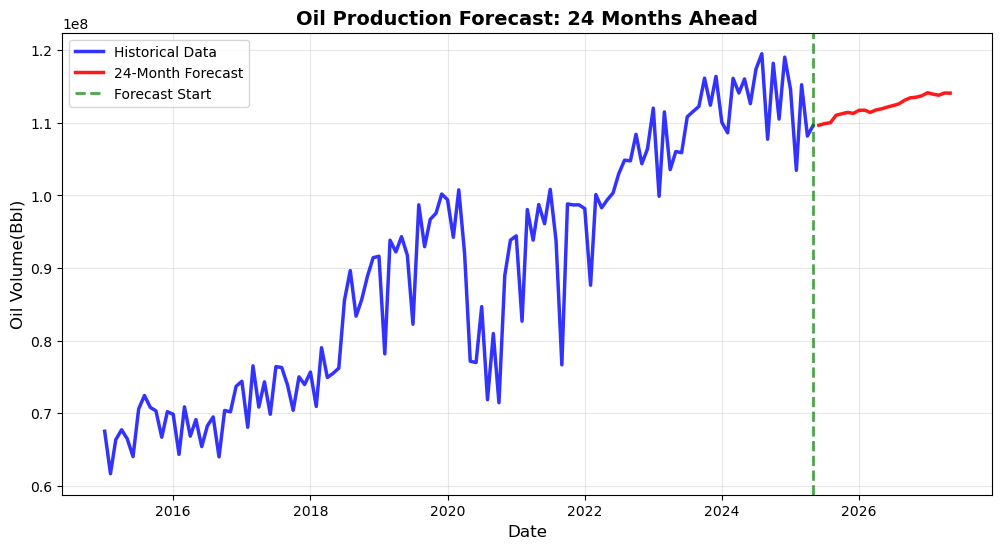

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df['Volume'], 'b-', linewidth=2.5, label='Historical Data', alpha=0.8)
ax.plot(forecast_df['Date'], forecast_df['Forecast_Volume'], 'r-', linewidth=2.5, label=f'{forecast_months}-Month Forecast', alpha=0.9)
ax.axvline(last_known_date, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start')
ax.set_title(f'Oil Production Forecast: {forecast_months} Months Ahead', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Oil Volume(Bbl)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

fig = ax.get_figure()
save_plot(fig, 'LSTM forecast')